# Vehicle Detection

This project will demonstrate how I setup pipeline to detect the vehicle so I will start from a sample images and along the way I will apply that to a series of images or video. 

At the end you will see the video with vehicle detection.

Let walk through the steps

* Explore data
* Choose color features
* Choose gradient features based with HOG
* Train classifiers to detect cars and non-cars
* Implement sliding windows to scan the images
* Search and classify
* Apply pipeline to video streams and tracking to follow the vehicles

## Let explore the data

Let look at training data we're going to use to build the classifier.

I examined the car and non-car of data download from [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) images, just a sample of data

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog
import vehicle_detection as my_function 
import glob
from sklearn.preprocessing import StandardScaler
%matplotlib inline
%load_ext autoreload
%autoreload 2

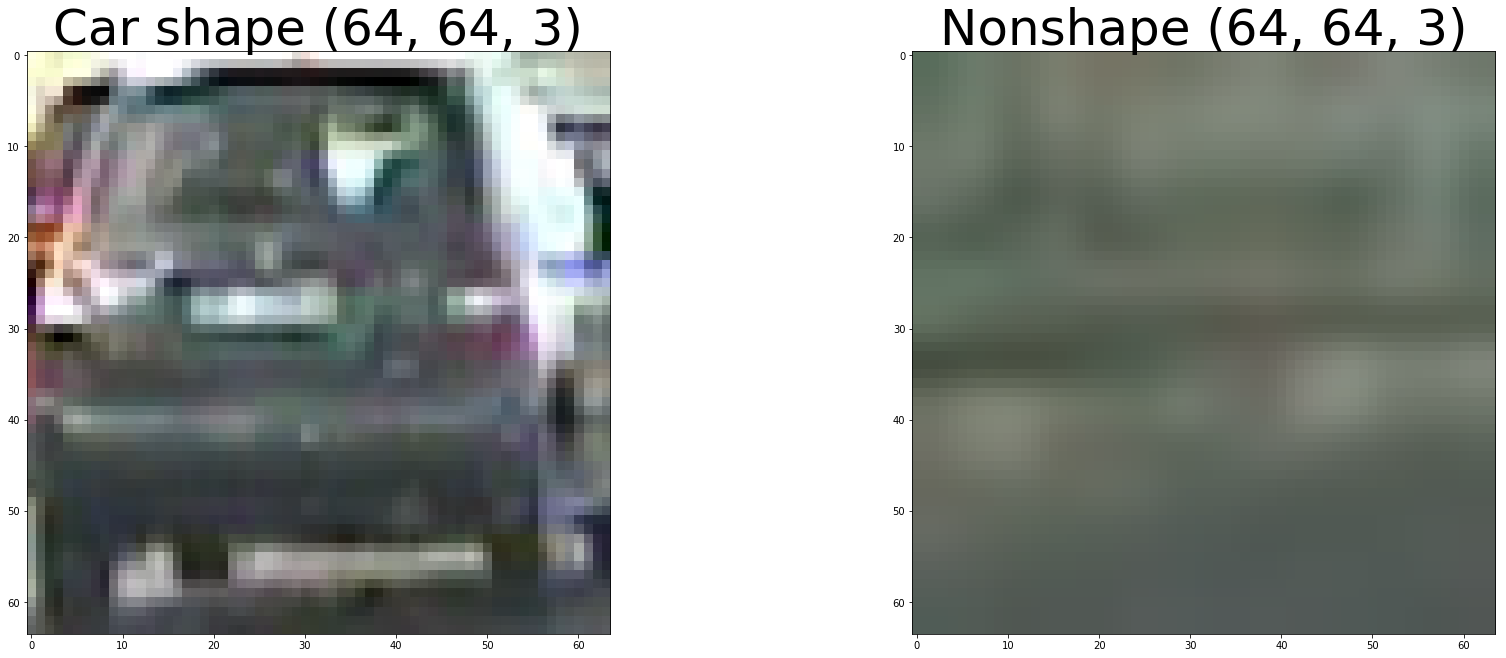

In [3]:
img1 = my_function.read_image('./test_images/car_1.png')
img2 = my_function.read_image('./test_images/noncar_1.png')
my_function.display_2_images(img1, img2, 
                             text_1='Car shape {}'.format(img1.shape), 
                             text_2='Nonshape {}'.format(img2.shape))

## Color Features

First, we look at color features aka channels (RGB, HSV, LUV, HLS, YUV, and YCrCb) 

By the help of `extract_features` function, allow me to experiment with varieties of parameters including HOG but we will look that shortly.

* Spatial Binning of Color
Simply said resize the image to smaller ratio while still having all relevant data

* Histogram of Color
Use histogram of color so I can focus on the overall magnitude of each color channels so the image of the car rotates horizontally or vertically, the histogram will be the same.

Last but not least, it's very important we normalize data which can be compared with the picture below between `Raw Features` and `Normalized Features`  I'll revisit it again at the train classifiers section.

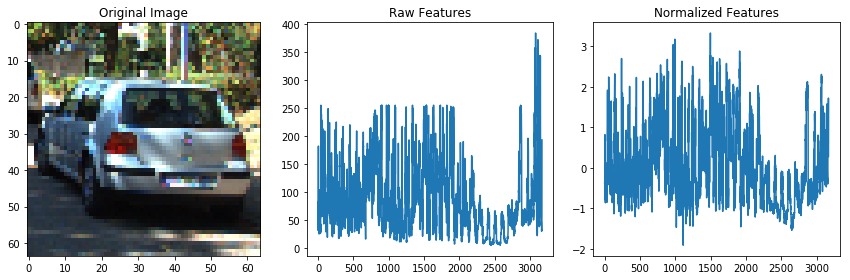

In [4]:
images = glob.glob('./test_images/*car*.png')
cars = []
notcars = []
for image in images:
    if 'noncar' in image:
        notcars.append(image)
    else:
        cars.append(image)                
        
car_features = my_function.extract_features(cars, color_space='RGB', 
                        spatial_size=(32, 32),hist_bins=32, 
                        spatial_feat=True, hist_feat=True, hog_feat=False)
notcar_features = my_function.extract_features(notcars, color_space='RGB', 
                        spatial_size=(32, 32),hist_bins=32, 
                        spatial_feat=True, hist_feat=True, hog_feat=False)   

X = np.vstack([car_features, notcar_features]).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

## HOG Feature

HOG or Histogram of Oriented Gradients provides me the distribution (histogram) of directions of gradients (oriented gradients) which I will use as another feature in addition to Color features.

Below is an example of code getting HOG features and image features in each channel with parameters of both Car and Non-car

* Color Space HSV
* Orient 9 (9 buckets of histogram)
* 4 Pixel per cell
* 2 Cell per block

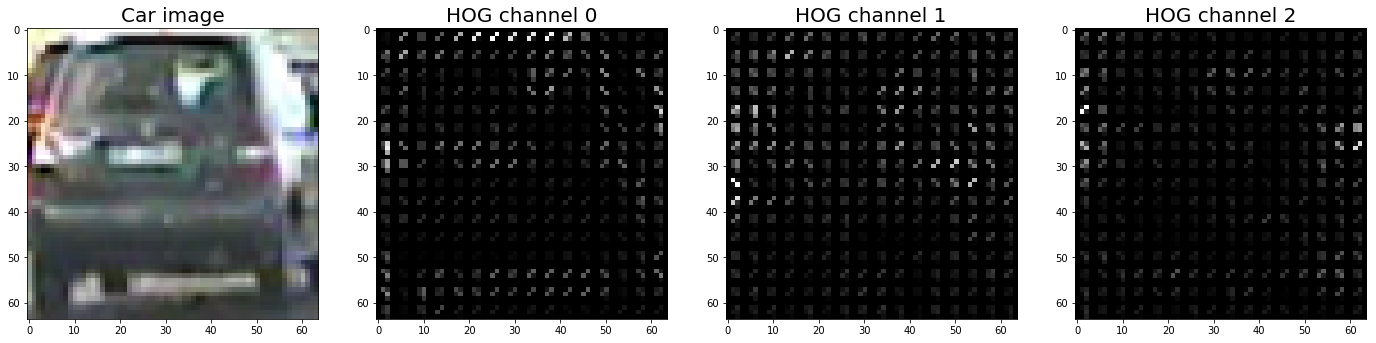

In [11]:
car_image = my_function.read_image('./test_images/car_1.png')
car_image_ycrcb = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)

f, (*ax) = plt.subplots(1, 4, figsize=(24, 9))
ax[0][0].imshow(car_image)
ax[0][0].set_title("Car image", fontsize=20)
for i in range(3):
    hog_features, img_feature = my_function.get_hog_features(
        car_image_ycrcb[:,:,i], 
        orient=9,pix_per_cell=4, cell_per_block=2, 
        vis=True, feature_vec=False)   
    ax[0][i+1].imshow(img_feature, cmap='gray')
    ax[0][i+1].set_title("HOG channel {}".format(i), fontsize=20)    


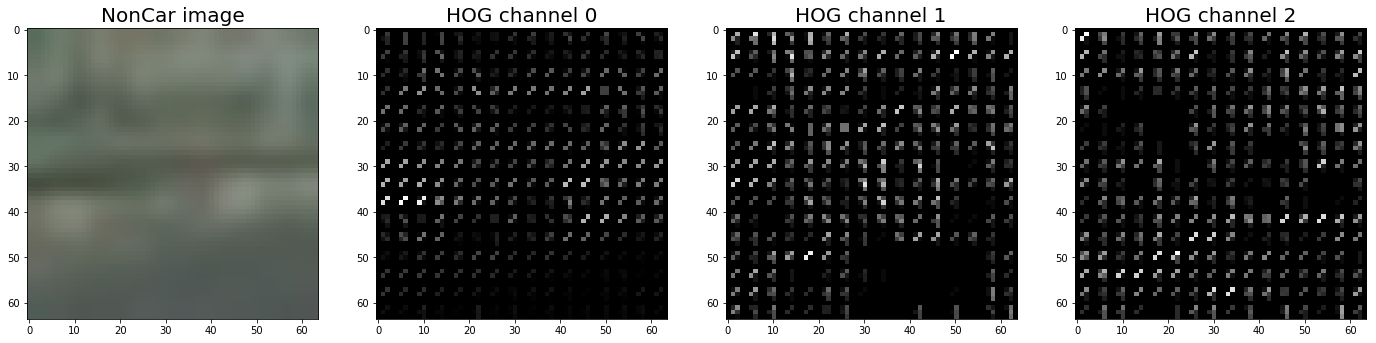

In [13]:
noncar_image = my_function.read_image('./test_images/noncar_1.png')
noncar_image_ycrcb = cv2.cvtColor(noncar_image, cv2.COLOR_RGB2YCrCb)

f, (*ax) = plt.subplots(1, 4, figsize=(24, 9))
ax[0][0].imshow(noncar_image)
ax[0][0].set_title("NonCar image", fontsize=20)
for i in range(3):
    hog_features, img_feature = my_function.get_hog_features(
        noncar_image_ycrcb[:,:,i], orient=9,
        pix_per_cell=4, cell_per_block=2, 
        vis=True, feature_vec=False)   
    ax[0][i+1].imshow(img_feature, cmap='gray')
    ax[0][i+1].set_title("HOG channel {}".format(i), fontsize=20)    

Here is data between normalized data and raw data, I just want to point out how important it is to visualize data before going to training classifier step.

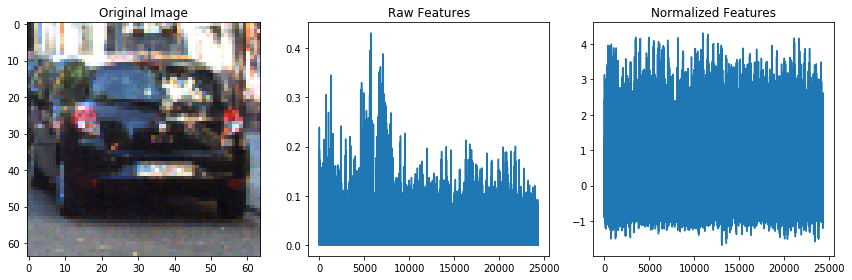

In [15]:
images = glob.glob('./test_images/*car*.png')
cars = []
notcars = []
for image in images:
    if 'noncar' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
car_features = my_function.extract_features(cars, color_space='YCrCb', 
                        orient=9,
                        pix_per_cell=4, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=False, hist_feat=False, hog_feat=True)
notcar_features = my_function.extract_features(notcars, color_space='YCrCb', 
                        orient=9,
                        pix_per_cell=4, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=False, hist_feat=False, hog_feat=True)

X = np.vstack([car_features, notcar_features]).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

### Train classifiers

At this step, I will show how I use the color and hog features extracted from earlier step and train my classifier with `Support Vector Machine` or `SVM` or to be more specific [Linear SVC](http://scikit-learn.org/stable/modules/svm.html#svc)

First, let talk about how I come up with what parameters to use to extract both Color and HOG features.

I decide to experiment with all combination of parameters by implementing a function `experiment_color` and `experiment_hog` by passing list of parameters (please see this function in `vehicle_detection.py` for more information)

#### Experiment with Color and HOG 

```
## Try all combination of Colors, Spatial and Histogram Bin 
experiment_color(cars, noncars, 
    ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb'],
    [8, 16, 32], [8, 16,32]
    )
    
## Try all combination    
experiment_hog(cars, noncars,
    ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb'],
    [9,12], [2,4,6,8], [2,4], [0,1,2,'ALL']
    )    
```

From above I can pass all parameters and let my classifier tried all combination and gave me the most accuracy parameters it could get.

I chose these parameters for my final classifier based on my experiment.

    color_space = 'YCrCb'
    hist_bins = 16
    spatial = (16,16)
    orient = 9
    pix_per_cell = 4
    cell_per_block = 2
    hog_channel = 'ALL'

#### Train the classfiers

Once we extract features of color and hog on both set of cars and non-cars images with the help of `extract_features` function I will get a very long vector of features value which will be passed into my classifier.

##### Training in details

*Normalize data* is very important like mentioned above to avoid outliers, bias or unbalance in the data itself, I implemented `normalize_data` function to get input of features and stack it up together before using [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to create scaler and normalize my car and non-car features then return  these data along with scaler out so, later on, we use the same scaler to my pipeline when classifying images.

*Splitting data* it's always a good practice to divide data into training and validation only so when predicting we want to make sure a classifier can predict unseen data.

Here is the snippet of code to normalize data, splitting data for training and validation then train my SVM classifier.

```
def normalize_data(car_features, noncar_features):
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    return X_scaler.transform(X), X_scaler
    
# define labels
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))    
    
# Normalize data
scaled_X, X_scaler = normalize_data(car_features, noncar_features) 

# good idea to split data into training and validation and random
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

# Time to train it
svc = LinearSVC()
svc.fit(X_train, y_train)
```

This is an example of training classifier with only 10 of the car and 10 non-car images only just for purpose of demonstration.

In [18]:
images = glob.glob('./test_images/*car*.png')
cars = []
notcars = []
for image in images:
    if 'noncar' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
# train classifier
color_space = 'YCrCb'
hist_bins = 16
spatial = (16,16)
orient = 9
pix_per_cell = 4
cell_per_block = 2
hog_channel = 'ALL'    

car_features = my_function.extract_features(cars, 
                    color_space=color_space, spatial_size=spatial, hist_bins=hist_bins,
                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
noncar_features = my_function.extract_features(notcars, 
                   color_space=color_space, spatial_size=spatial, hist_bins=hist_bins,
                   orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

svc, X_scaler, pred = my_function.train_classifier(car_features, noncar_features, visualize=True)

Test Accuracy of SVC =  1.0
My SVC predicts:  [ 1.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  0.  1.]


### Implement sliding windows to scan the images

At this step, we have classifiers with optimum features we choose from above experiments already. Now I will start using my classifiers to image however I don't know what location to look for so I will use sliding windows to move and overlap each others to scan over the image avoid the area I know there is no car for sure (sky, tree) so I start at location of y value of 400 until the bottom of the image.

The snippet code below shows sliding windows of size 128*128 pixels with 25% each overlap both horizontal and vertical direction.

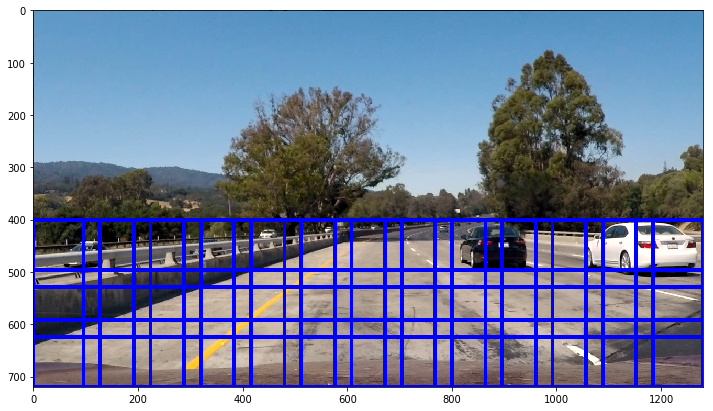

In [22]:
test_image = my_function.read_image('./test_images/test1.jpg')
window_list = my_function.slide_window(test_image,y_start_stop=[400,None],xy_window=(128, 128), xy_overlap=(0.25, 0.25))
window_image = my_function.draw_boxes(test_image, window_list)
plt.figure(figsize=(12,12))
plt.imshow(window_image)

### Search and classify



#### Multiple Detections & False Positive

### Tracking Pipeline

### Summary